In [1]:
%matplotlib inline

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
from pt_tex_synth import *
import os, time

## Run the cell below

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = 256 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# Plotting and saving functions.
unloader = transforms.ToPILImage()  # reconvert into PIL image

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    #plt.pause(0.001) # pause a bit so that plots are updated

def imsave(tensor, savepath=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    image.save(savepath)  

# Load the VGG19 weights and model architecture.
cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Part 1: Texture Synthesis

## Edit the cell below to specify which original image and which layer, then run!

In [3]:
## Specify which image, which layer, and other important synthesis parameters.
orig_im_name = "tulips.jpg"
layer = 'pool1' # Choose either pool1, pool2, pool3 or pool4.
num_steps = 1000
stim_dir = '/home/users/akshayj/TextureSynthesis/stimuli/textures/orig_color' # change to match stim directory.
out_dir = 'output' # Directory to save the image in (relative to stim_dir)

# Uncomment the line below to see a list of all the original images you can play around with.
#print(os.listdir(stim_dir))

In [4]:
# After specifying above, run this cell to start the texture synthesis!
saveName = '{}_{}.png'.format(layer, orig_im_name.split('.')[0]) # Save as: e.g. pool2_cherries.png

# Specify the texture image to match
orig_img = image_loader(stim_dir + '/' + orig_im_name)

# Randomly initialize white noise input image
init_img = torch.randn(orig_img.data.size(), device=device)

# Make the output directory, if it doesn't already exist.
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

# Select layer
all_layers = ['conv1_1', 'pool1', 'pool2', 'pool3', 'pool4'];
this_layers = all_layers[:all_layers.index(layer)+1]

# Run!
t = time.time()
output_img = run_texture_synthesis(cnn, cnn_normalization_mean, cnn_normalization_std, orig_img, 
                                    init_img, num_steps=num_steps, style_layers=this_layers, 
                                    saveLoc=[stim_dir + '/' + out_dir, saveName])

# Save the image you just generated
imsave(output_img, stim_dir + '/' + out_dir + '/' + saveName);

elapsed = time.time() - t
print('Done synthesizing! Took {} seconds'.format(elapsed))

Building the style transfer model..
Optimizing..


pt_tex_synth.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
pt_tex_synth.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Step #50 style loss: 410.900635
Step #100 style loss: 16.895628
Step #150 style loss: 3.148006
Step #200 style loss: 1.371273
Step #250 style loss: 1.002581
Step #300 style loss: 0.502652
Step #350 style loss: 0.305822
Step #400 style loss: 0.114390
Step #450 style loss: 0.045732
Step #500 style loss: 0.023051
Step #550 style loss: 0.014793
Step #600 style loss: 0.008940
Step #650 style loss: 0.006942
Step #700 style loss: 0.007352
Step #750 style loss: 0.004297
Step #800 style loss: 0.002993
Step #850 style loss: 0.002389
Step #900 style loss: 0.002009
Step #950 style loss: 0.002791
Step #1000 style loss: 0.001397
Done synthesizing! Took 32.1879529953 seconds


## Run the cell below to plot the texture you just generated.

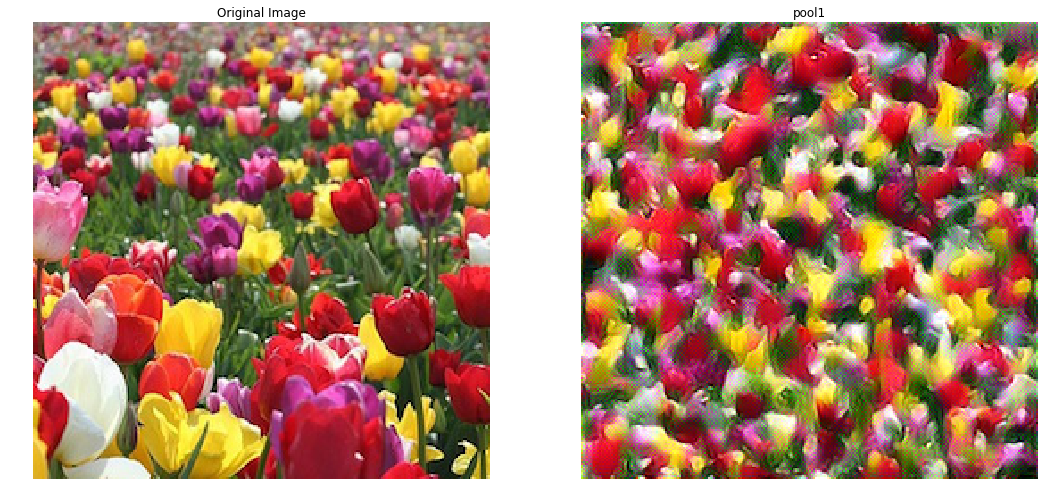

In [8]:
def plot_textures(orig_im_name, layers=[], orig_img = orig_img, save_dir = stim_dir + '/' + out_dir):
    
    plt.figure(figsize=(18,10))

    # First plot the original image
    plt.subplot(1,len(layers)+1,1);
    imshow(orig_img, title='Original Image')
    plt.axis('off');
    
    # then plot everything else.
    for i in range(2, len(layers)+2):
        img = image_loader('{}/{}_{}.png'.format(save_dir,layers[i-2],orig_im_name))
        plt.subplot(1,len(layers)+1,i);
        imshow(img, title=layers[i-2])
        plt.axis('off');

## you have to specify the image name and which layers to plot
plot_textures('tulips', ['pool1'], orig_img)

# Part 2: Analysis of Behavior

In [10]:
# Load the features (just run this once, its a pretty large file)
tex_features = np.load('/scratch/groups/jlg/MBCT/tex_features.npy')
orig_features = np.load('/scratch/groups/jlg/MBCT/orig_features.npy')

def plot_feature_similarity(feat_sim, layers=['pool1', 'pool2', 'pool4']):
    p1,p2,p4 = np.mean(feat_sim['pool1']), np.mean(feat_sim['pool2']), np.mean(feat_sim['pool4'])

    fig,ax = plt.subplots(figsize=(10,10))
    plt.plot([1,2,3], [p1,p2,p4], 'o--');

    plt.ylim([0,1]);
    plt.ylabel('Similarity of textures to original')
    plt.xlabel('Layer from which textures were generated')
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['Pool1', 'Pool2', 'Pool4']);


IOError: [Errno 14] Bad address

In [ ]:
## Set the observer layer with which to analyze the images.
obs_layer = 'pool2' ## Change this to whatever you want.

tex_feats = tex_features['{}_obs'.format(obs_layer)]
orig_feats = orig_features['{}_obs'.format(obs_layer)]

feat_sim = dict('pool1', [], 'pool2', [], 'pool3', [], 'pool4', [])

# Loop through each texture image.
for i in range(tex_features['nSamples']-1):
    lyr = tex_features['layer'][i]
    img = tex_features['image'][i]
    if '.' in img:
        img = img.split('.')[0]
    
    # Find the features of the corresponding original image.
    orig_feat = orig_feats[orig_features['image'].index(img),:]
    
    # Compute the similarity
    similarity = np.corrcoef(tex_feats[i,:], orig_feat)[0,1]
    feat_sim[lyr].append(similarity)

# Plot the feature similarity
plot_feature_similarity(feat_sim)